In [1]:
!apt-get install libmagickwand-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gir1.2-freedesktop
  gir1.2-gdkpixbuf-2.0 gir1.2-rsvg-2.0 gsfonts imagemagick-6-common
  libcairo-script-interpreter2 libcairo2-dev libcupsfilters1 libcupsimage2
  libdjvulibre-dev libdjvulibre-text libdjvulibre21 libgdk-pixbuf2.0-dev
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 liblcms2-dev liblqr-1-0
  liblqr-1-0-dev libmagickcore-6-arch-config libmagickcore-6-headers
  libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra libmagickcore-6.q16-dev
  libmagickwand-6-headers libmagickwand-6.q16-3 libmagickwand-6.q16-dev
  libpixman-1-dev librsvg2-dev libwmf-dev libwmf0.2-7 libxcb-shm0-dev
  poppler-data
Suggested packages:
  fonts-noto ghostscript-x libcairo2-doc inkscape libjxr-tools librsvg2-doc
  libwmf-doc libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts

In [2]:
%pip install Wand

     |████████████████████████████████| 143kB 4.1MB/s 


In [5]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf

In [6]:
%pip install azure-storage-blob

In [7]:
import os, uuid
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__

try:
    print("Azure Blob storage v" + __version__ + " - Python quickstart sample")
    # Quick start code goes here
except Exception as ex:
    print('Exception:')
    print(ex)

Azure Blob storage v12.7.1 - Python quickstart sample


In [9]:
STORAGEACCOUNTNAME= "hpegoal"
STORAGEACCOUNTKEY= "GO0LxLX+2O/yfNaOAe9lbENXe71828ywoh3Yo4vkqW8WKdlL4RdLrhXbcgg1p/wJKYYpNMf712nQPkLYjeRKUA=="
LOCALFILENAME= "0"
CONTAINERNAME= "train"
local_file_name = "0.mp4"

In [10]:
 connect_str  = 'DefaultEndpointsProtocol=https;AccountName=hpegoal;AccountKey=GO0LxLX+2O/yfNaOAe9lbENXe71828ywoh3Yo4vkqW8WKdlL4RdLrhXbcgg1p/wJKYYpNMf712nQPkLYjeRKUA==;EndpointSuffix=core.windows.net'
!pwd

/content


In [11]:
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [12]:
blob_client = blob_service_client.get_blob_client(container=CONTAINERNAME, blob=local_file_name)

In [13]:
blob_client.get_blob_properties()

{'name': '0.mp4', 'container': 'train', 'snapshot': None, 'version_id': None, 'is_current_version': None, 'blob_type': <BlobType.BlockBlob: 'BlockBlob'>, 'metadata': {}, 'encrypted_metadata': None, 'last_modified': datetime.datetime(2021, 1, 26, 7, 5, 30, tzinfo=datetime.timezone.utc), 'etag': '"0x8D8C1C8C447BF98"', 'size': 229865386, 'content_range': None, 'append_blob_committed_block_count': None, 'is_append_blob_sealed': None, 'page_blob_sequence_number': None, 'server_encrypted': True, 'copy': {'id': None, 'source': None, 'status': None, 'progress': None, 'completion_time': None, 'status_description': None, 'incremental_copy': None, 'destination_snapshot': None}, 'content_settings': {'content_type': 'video/mp4', 'content_encoding': None, 'content_language': None, 'content_md5': None, 'content_disposition': None, 'cache_control': None}, 'lease': {'status': 'unlocked', 'state': 'available', 'duration': None}, 'blob_tier': 'Hot', 'rehydrate_priority': None, 'blob_tier_change_time': No

In [14]:
with open("./sample.mp4", "wb") as my_blob:
    blob_data = blob_client.download_blob()
    blob_data.readinto(my_blob)

In [15]:
import matplotlib.pyplot as plt
import imageio

In [16]:
video_file = '/content/sample.mp4'
vid = imageio.get_reader(video_file, 'ffmpeg')

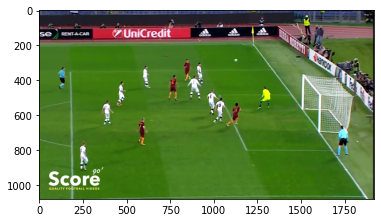

In [86]:
sec = 166
frame = vid.get_data(30*sec)
plt.imshow(frame)

In [87]:
frame[0][0].shape

(3,)

In [88]:
np.min(frame[:,:,1])

0

In [163]:
frame_1 = np.zeros(frame.shape)
frame_1 = frame.astype(np.float)/255
for y in range(frame.shape[0]):
    for x in range(frame.shape[1]):
        if (frame[y][x][1]<(np.max([frame[y][x][0],frame[y][x][2]]))):
            frame_1[y][x] *= 0

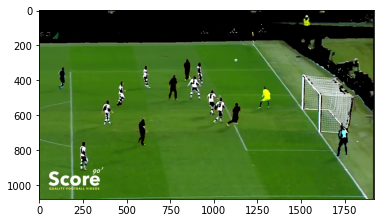

In [164]:
plt.imshow(frame_1)

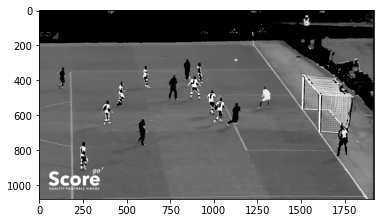

In [169]:
from skimage import color

frame_2 = color.rgb2gray(frame_1)
plt.imshow(frame_2, cmap = 'gray')

In [173]:
v = 0
for i in range(frame_2.shape[0]):
    if (np.sum(frame_2[i])/frame_2.shape[1])>0.2:
        v = i
        break

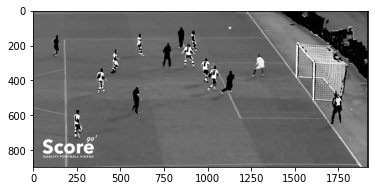

In [175]:
frame_3 = frame_2[v:]
plt.imshow(frame_3, cmap='gray')

In [176]:
frame_3.shape

(896, 1920)

In [177]:
from wand.image import Image
from wand.color import Color

In [182]:
frame_3_3 = np.zeros((frame_3.shape[0], frame_3.shape[1], 3))
frame_3_3[:,:,0] = frame_3
frame_3_3[:,:,1] = frame_3
frame_3_3[:,:,2] = frame_3

In [183]:
img = Image.from_array(array=frame_3_3)
img.background_color = Color('skyblue') 
img.virtual_pixel = 'background'
args = ( 
    1260,0,1719,0,
    1919,893,1719,893,
    0,893,0,893,
) 
# affline distortion using distort function 
img.distort('affine', args) 

1

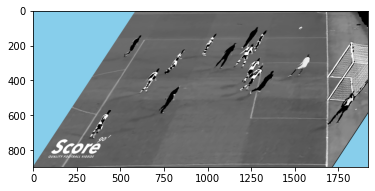

In [185]:
plt.imshow(np.array(img))

In [203]:
frame_4 = np.array(img)
frame_4 = frame_4[:,frame_4.shape[1]-frame_4.shape[0]:]
frame_4.shape

(896, 896, 3)

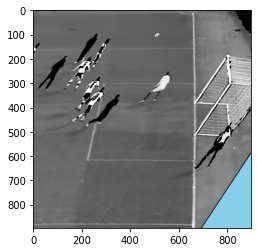

In [193]:
plt.imshow(frame_4)

In [198]:
from scipy.ndimage.filters import gaussian_filter

frame_4_blur = gaussian_filter(frame_4, sigma=3)

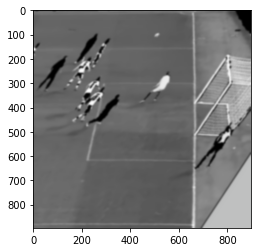

In [199]:
plt.imshow(frame_4_blur)

In [208]:
def sobel_edge(img):
    e = np.zeros((img.shape[0]-2,img.shape[1]-2))
    kx = np.array(
            [
             np.array([-1,-2,-1]),
             np.array([0,0,0]),
             np.array([1,2,1])
            ],
    )
    ky = kx.T
    for i in range(img.shape[0]-2):
        for j in range(img.shape[1]-2):
            x = np.sum(kx*img[i:i+3,j:j+3])
            y = np.sum(ky*img[i:i+3,j:j+3])
            e[i][j] = np.sqrt(x**2 + y**2)
    return e

In [215]:
e = sobel_edge(frame_3)
plt.imsave('e.png', e, cmap='gray')

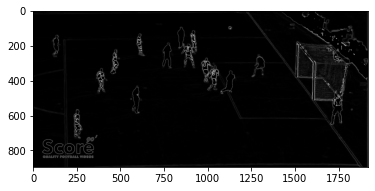

In [214]:
plt.imshow(e, cmap='gray')